<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko). Edited by Sergey Kolchenko (@KolchenkoSergey). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

# <center> Assignment #2. Spring 2019
## <center>  Competition 2. Predicting Medium articles popularity with Ridge Regression <br>(beating baselines in the "Medium" competition)
    
<img src='../../img/medium_claps.jpg' width=40% />


In this [competition](https://www.kaggle.com/c/how-good-is-your-medium-article) we are predicting Medium article popularity based on its features like content, title, author, tags, reading time etc. 

Prior to working on the assignment, you'd better check out the corresponding course material:
 1. [Classification, Decision Trees and k Nearest Neighbors](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic03_decision_trees_kNN/topic3_decision_trees_kNN.ipynb?flush_cache=true), the same as an interactive web-based [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-3-decision-trees-and-knn) (basics of machine learning are covered here)
 2. Linear classification and regression in 5 parts: 
    - [ordinary least squares](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-1-ols)
    - [linear classification](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-2-classification)
    - [regularization](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-3-regularization)
    - [logistic regression: pros and cons](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-4-more-of-logit)
    - [validation](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-5-validation)
 3. You can also practice with demo assignments, which are simpler and already shared with solutions: 
    - " Sarcasm detection with logistic regression": [assignment](https://www.kaggle.com/kashnitsky/a4-demo-sarcasm-detection-with-logit) + [solution](https://www.kaggle.com/kashnitsky/a4-demo-sarcasm-detection-with-logit-solution)
    - "Linear regression as optimization": [assignment](https://www.kaggle.com/kashnitsky/a4-demo-linear-regression-as-optimization/edit) (solution cannot be officially shared)
    - "Exploring OLS, Lasso and Random Forest in a regression task": [assignment](https://www.kaggle.com/kashnitsky/a6-demo-linear-models-and-rf-for-regression) + [solution](https://www.kaggle.com/kashnitsky/a6-demo-regression-solution)
 4. Baseline with Ridge regression and "bag of words" for article content, [Kernel](https://www.kaggle.com/kashnitsky/ridge-countvectorizer-baseline)
 5. Other [Kernels](https://www.kaggle.com/c/how-good-is-your-medium-article/kernels?sortBy=voteCount&group=everyone&pageSize=20&competitionId=8673) in this competition. You can share yours as well, but not high-performing ones (Public LB MAE shall be > 1.5). Please don't spoil the competitive spirit.  
 6. If that's still not enough, watch two videos (Linear regression and regularization) from here [mlcourse.ai/video](https://mlcourse.ai/video), the second one on LTV prediction is smth that you won't typically find in a MOOC - real problem, real metrics, real data.

**Your task:**
 1. "Freeride". Come up with good features to beat the baselines "A2 baseline (10 credits)" and "A2 strong baseline (20 credits)". As names suggest, you'll get 10 more credits for beating the first one, and 10 more (20 in total) for beating the second one. You need to name your [team](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/team) (out of 1 person) in full accordance with the [course rating](https://docs.google.com/spreadsheets/d/1LAy1eK8vIONzIWgcCEaVmhKPSj579zK5lrECf_tQT60/edit?usp=sharing) (for newcomers: you need to name your team with your real full name). You can think of it as a part of the assignment.
 2. If you've beaten "A2 baseline (10 credits)" or performed better, you need to upload your solution as described in [course roadmap](https://mlcourse.ai/roadmap) ("Kaggle Inclass Competition Medium"). For all baselines that you see on Public Leaderboard, it's OK to beat them on Public LB as well. But 10 winners will be defined according to the private LB, which will be revealed by @yorko on March 11. 
 
 ### <center> Deadline for A2: 2019 March 10, 20:59 GMT (London time)
 
### How to get help
In [ODS Slack](https://opendatascience.slack.com) (if you still don't have access, fill in the [form](https://docs.google.com/forms/d/1BMqcUc-hIQXa0HB_Q2Oa8vWBtGHXk8a6xo5gPnMKYKA/edit) mentioned on the mlcourse.ai main page), we have a channel **#mlcourse_ai_news** with announcements from the course team.
You can discuss the course content freely in the **#mlcourse_ai** channel (we still have a huge Russian-speaking group, they have a separate channel **#mlcourse_ai_rus**).

Please stick this special threads for your questions:
 - [#a2_medium](https://opendatascience.slack.com/archives/C91N8TL83/p1549882568052400) 
 
Help each other without sharing actual code. Our TA Artem @datamove is there to help (only in the mentioned thread, do not write to him directly).

In [1]:
import os
import json
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from bs4 import BeautifulSoup

In [2]:
PATH_TO_DATA = 'data/medium' # modify this if you need to

The following code will help to throw away all HTML tags from an article content.

In [2]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

Supplementary function to read a JSON line without crashing on escape characters.

In [3]:
def read_json_line(line=None):
    result = None
    try:        
        result = json.loads(line)
    except Exception as e:      
        # Find the offending character index:
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))      
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)     
        return read_json_line(line=new_line)
    return result

Extract features `content`, `published`, `title` and `author`, write them to separate files for train and test sets.

In [11]:
def extract_features_and_write(path_to_data,
                               inp_filename, is_train=True):
    
    features = ['content', 'published', 'title', 'author', 'tags']
    prefix = 'train' if is_train else 'test'
    feature_files = [open(os.path.join(path_to_data,
                                       '{}_{}.txt'.format(prefix, feat)),
                          'w', encoding='utf-8')
                     for feat in features]
    content_list = []
    published_list = []
    author_list = []
    title_list = []
    tags_list = []
    
    with open(os.path.join(path_to_data, inp_filename), 
              encoding='utf-8') as inp_json_file:

        for line in tqdm_notebook(inp_json_file):
            json_data = read_json_line(line)
            
            # You code here
            content = json_data['content'].replace('\n', ' ').replace('\r', ' ')
            content_no_html_tags = strip_tags(content)
            content_list.append(content_no_html_tags)
            
            published = json_data['published']['$date']

            published_list.append(published)
            
            title = json_data['title'].split('\u2013')[0].strip() #'Medium Terms of Service – Medium Policy – Medium'
            title = title.replace('\n', ' ').replace('\r', ' ')
            title_list.append(title)
            
            author = json_data['meta_tags']['author'].strip()
            author_list.append(author)
            
            tags_str = []
            soup = BeautifulSoup(content, 'lxml')
            try:
                tag_block = soup.find('ul', class_='tags')
                tags = tag_block.find_all('a')
                for tag in tags:
                    tags_str.append(tag.text.translate({ord(' '):None, ord('-'):None}))
                tags = ' '.join(tags_str)
            except Exception:
                tags = ' '
                #tags = 'None'
            tags_list.append(tags)
            #print(tags)
    
    feature_files[0].write('\n'.join(content_list))
    feature_files[1].write('\n'.join(published_list))
    feature_files[2].write('\n'.join(title_list))
    feature_files[3].write('\n'.join(author_list))
    feature_files[4].write('\n'.join(tags_list))
    
    feature_files[0].close()
    feature_files[1].close()
    feature_files[2].close()
    feature_files[3].close()
    feature_files[4].close()

In [12]:
extract_features_and_write(PATH_TO_DATA, 'train.json', is_train=True)

In [13]:
extract_features_and_write(PATH_TO_DATA, 'test.json', is_train=False)

**Add the following groups of features:**
    - Tf-Idf with article content (ngram_range=(1, 2), max_features=100000 but you can try adding more)
    - Tf-Idf with article titles (ngram_range=(1, 2), max_features=100000 but you can try adding more)
    - Time features: publication hour, whether it's morning, day, night, whether it's a weekend
    - Bag of authors (i.e. One-Hot-Encoded author names)

In [35]:
#Adding Time features: publication hour, whether it's morning, afternoon, evening, night, whether it's a weekend

train_time_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_published.txt'), header=None)
train_time_df.columns=['datetime']
train_time_df['datetime'] = pd.to_datetime(train_time_df['datetime'], format='%Y-%m-%dT%H:%M:%S.%fZ')
train_time_df['hour'] =  pd.DatetimeIndex(train_time_df['datetime']).hour
train_time_df['month'] =  pd.DatetimeIndex(train_time_df['datetime']).month

train_time_df['morning'] = train_time_df['hour'].apply(lambda x: 1 if (x>=6) & (x<12) else 0)
train_time_df['afternoon'] = train_time_df['hour'].apply(lambda x: 1 if (x>=12) & (x<17) else 0)
train_time_df['evening'] = train_time_df['hour'].apply(lambda x: 1 if (x>=17) & (x<22) else 0)
train_time_df['night'] = train_time_df['hour'].apply(lambda x: 1 if (x>=22) | (x<6) else 0)
train_time_df['weekend'] = ((pd.DatetimeIndex(train_time_df['datetime']).dayofweek) // 5 == 1).astype(int)
train_time_df = train_time_df.drop(columns=['hour'])
train_time_df = train_time_df.drop(columns = ['datetime']) #dropped since csr_matrix could not process the datetime object

In [36]:
train_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62313 entries, 0 to 62312
Data columns (total 6 columns):
month        62313 non-null int64
morning      62313 non-null int64
afternoon    62313 non-null int64
evening      62313 non-null int64
night        62313 non-null int64
weekend      62313 non-null int32
dtypes: int32(1), int64(5)
memory usage: 2.6 MB


In [37]:
X_train_time_features_sparse = csr_matrix(train_time_df)

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(1, 3), max_features=75000)
with open(os.path.join(PATH_TO_DATA, 'train_tags.txt'), encoding="utf8") as inp_train_file:
    X_train_tags_sparse = cv.fit_transform(inp_train_file)
with open(os.path.join(PATH_TO_DATA, 'test_tags.txt'), encoding="utf8") as inp_test_file:
    X_test_tags_sparse = cv.transform(inp_test_file)
X_train_tags_sparse.shape, X_test_tags_sparse.shape


((62313, 75000), (34645, 75000))

In [40]:
author_cv = CountVectorizer(ngram_range=(1, 3), max_features=50000)
with open(os.path.join(PATH_TO_DATA, 'train_author.txt'), encoding="utf8") as inp_train_file:
    X_train_author_sparse = author_cv.fit_transform(inp_train_file)
with open(os.path.join(PATH_TO_DATA, 'test_author.txt'), encoding="utf8") as inp_test_file:
    X_test_author_sparse = author_cv.transform(inp_test_file)
X_train_author_sparse.shape, X_test_author_sparse.shape

((62313, 50000), (34645, 50000))

In [41]:
#Tf-Idf with article titles (ngram_range=(1, 2), max_features=100000 but you can try adding more)
contentvectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=150000, stop_words='english')
X_train_content_sparse = contentvectorizer.fit_transform(open(os.path.join(PATH_TO_DATA, 'train_content.txt'), 'r', encoding='utf-8'))

In [42]:
#Tf-Idf with article titles (ngram_range=(1, 2), max_features=100000 but you can try adding more)
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=150000, stop_words='english')
X_train_title_sparse = vectorizer.fit_transform(open(os.path.join(PATH_TO_DATA, 'train_title.txt'), 'r', encoding='utf-8'))

In [43]:
#Repeat the same transformations for test set also

#Adding Time features: publication hour, whether it's morning, afternoon, evening, night, whether it's a weekend

test_time_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_published.txt'), header=None)
test_time_df.columns=['datetime']
test_time_df['datetime'] = pd.to_datetime(test_time_df['datetime'], format='%Y-%m-%dT%H:%M:%S.%fZ')
test_time_df['hour'] =  pd.DatetimeIndex(test_time_df['datetime']).hour
test_time_df['month'] =  pd.DatetimeIndex(test_time_df['datetime']).month

test_time_df['morning'] = test_time_df['hour'].apply(lambda x: 1 if (x>=6) & (x<12) else 0)
test_time_df['afternoon'] = test_time_df['hour'].apply(lambda x: 1 if (x>=12) & (x<17) else 0)
test_time_df['evening'] = test_time_df['hour'].apply(lambda x: 1 if (x>=17) & (x<22) else 0)
test_time_df['night'] = test_time_df['hour'].apply(lambda x: 1 if (x>=22) | (x<6) else 0)
test_time_df['weekend'] = ((pd.DatetimeIndex(test_time_df['datetime']).dayofweek) // 5 == 1).astype(int)
test_time_df = test_time_df.drop(columns=['hour'])
test_time_df = test_time_df.drop(columns = ['datetime']) #dropped since csr_matrix could not process the datetime object

X_test_time_features_sparse = csr_matrix(test_time_df)


In [44]:
#Tf-Idf with article titles (ngram_range=(1, 2), max_features=100000 but you can try adding more)
contentvectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=150000, stop_words='english')
X_test_content_sparse = contentvectorizer.fit_transform(open(os.path.join(PATH_TO_DATA, 'test_content.txt'), 'r', encoding='utf-8'))

#Tf-Idf with article titles (ngram_range=(1, 2), max_features=100000 but you can try adding more)
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=150000, stop_words='english')
X_test_title_sparse = vectorizer.fit_transform(open(os.path.join(PATH_TO_DATA, 'test_title.txt'), 'r', encoding='utf-8'))

In [45]:
test_time_df.head()

,month,morning,afternoon,evening,night,weekend
0,2,0,0,1,0,0
1,12,0,1,0,0,0
2,2,0,0,1,0,0
3,2,0,0,1,0,0
4,10,0,0,0,1,0


**Join all sparse matrices.**

from sklearn.feature_extraction.text import CountVectorizer
content_cv = CountVectorizer(ngram_range=(1, 2), max_features=150000)
X_train_content_sparse = content_cv.fit_transform(open(os.path.join(PATH_TO_DATA, 'train_content.txt'), 'r', encoding='utf-8'))
X_test_content_sparse = content_cv.fit_transform(open(os.path.join(PATH_TO_DATA, 'test_content.txt'), 'r', encoding='utf-8'))


#X_train_title_sparse = cv.fit_transform(open(os.path.join(PATH_TO_DATA, 'train_title.txt'), 'r', encoding='utf-8'))
#X_test_title_sparse = cv.fit_transform(open(os.path.join(PATH_TO_DATA, 'test_title.txt'), 'r', encoding='utf-8'))
## This messes the mae values totally - not sure how it worked for yorko

In [48]:
X_train_sparse = hstack([X_train_content_sparse, X_train_title_sparse,
                         X_train_author_sparse, X_train_tags_sparse,
                         X_train_time_features_sparse]).tocsr()

In [49]:
X_test_sparse = hstack([X_test_content_sparse, X_test_title_sparse,
                        X_test_author_sparse, X_test_tags_sparse,
                        X_test_time_features_sparse]).tocsr()

**Read train target and split data for validation.**

In [50]:
train_target = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_log1p_recommends.csv'), 
                           index_col='id')
y_train = train_target['log_recommends'].values

In [51]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_part_sparse = X_train_sparse[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_valid_sparse =  X_train_sparse[train_part_size:, :]
y_valid = y_train[train_part_size:]

**Train a simple Ridge model and check MAE on the validation set.**

In [52]:
ridge = Ridge(alpha=15.0, max_iter=1500, random_state=17, normalize=True)
ridge.fit(X_train_part_sparse, y_train_part)

Ridge(alpha=15.0, copy_X=True, fit_intercept=True, max_iter=1500,
   normalize=True, random_state=17, solver='auto', tol=0.001)

In [53]:
ridge_pred = ridge.predict(X_valid_sparse)
valid_mae = mean_absolute_error(y_valid, ridge_pred)
valid_mae, np.expm1(valid_mae)

(2.0720444880223856, 6.941041897694572)

In [54]:
ridge_pred

array([5.78305473, 5.05524643, 3.6408392 , ..., 3.12996676, 4.07541378,
       4.81480179])

In [55]:
y_valid

array([3.61092, 2.77259, 1.09861, ..., 3.55535, 1.09861, 4.43082])

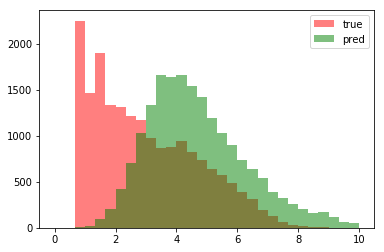

In [56]:
from matplotlib import pyplot as plt
plt.hist(y_valid, bins=30, alpha=.5, color='red', label='true', range=(0,10));
plt.hist(ridge_pred, bins=30, alpha=.5, color='green', label='pred', range=(0,10));
plt.legend()

In [57]:
X_test_sparse.shape, X_train_sparse.shape

((34645, 425006), (62313, 425006))

In [58]:
X_train_author_sparse.shape, X_train_content_sparse.shape, X_train_tags_sparse.shape, X_train_title_sparse.shape

((62313, 50000), (62313, 150000), (62313, 75000), (62313, 150000))

In [59]:
X_test_author_sparse.shape, X_test_content_sparse.shape, X_test_tags_sparse.shape, X_test_title_sparse.shape

((34645, 50000), (34645, 150000), (34645, 75000), (34645, 150000))

In [60]:
ridge.fit(X_train_sparse, y_train)
ridge_test_pred = ridge.predict(X_test_sparse)

In [62]:
def write_submission_file(prediction, filename,
                          path_to_sample=os.path.join(PATH_TO_DATA, 
                                                      'sample_submission.csv')):
    submission = pd.read_csv(path_to_sample, index_col='id')
    
    submission['log_recommends'] = prediction
    submission.to_csv(filename)

In [63]:
write_submission_file(ridge_test_pred, os.path.join(PATH_TO_DATA,
                                                    'ridge.csv'))

In [64]:
***********

SyntaxError: invalid syntax (<ipython-input-64-9b9e3a4d85ae>, line 1)

**Train the same Ridge with all available data, make predictions for the test set and form a submission file.**

In [ ]:
# You code here
ridge_pred = ridge.predict(X_valid_sparse)
valid_mae = mean_absolute_error(y_valid, ridge_pred)
valid_mae, np.expm1(valid_mae)

In [ ]:
ridge.fit(X_train_sparse, y_train)
ridge_test_pred = ridge.predict(X_test_sparse)

In [ ]:
write_submission_file(ridge_test_pred, os.path.join(PATH_TO_DATA,
                                                    'assignment2_medium_submission.csv'))

## Baseline score - 1.93742

## Best Score, alpha = 15, With tags added - 1.93676 (1.7305557882663936, 4.643789789047516) 

With CV, alpha = 1, score = 2.14179 (1.5165955255584675, 3.556685638345537)

## Alpha=15 gave the best result.

Alpha = 15, year + time scaled features. Score = 2.60118 (1.715779665374717, 4.561009549186621)

Score = 2.47216 (1.315476772891963, 2.7265272689586086)

Score = 2.64860 (1.8615588641275571, 5.433758313328659)

Score = 1.98072 (2.2930650394137206, 8.905251186687) - tags broken up into 5 cols

Score = 2.25901 with grid search (2.2930650394137206, 8.905251186687)

## Score =  1.75936 with countvec of tags (2.086456897869083, 7.056320171562094)

## Score = 1.70898 with countvec of author (2.0720444880223856, 6.941041897694572)

**Now's the time for dirty Kaggle hacks. Form a submission file with all zeros. Make a submission. What do you get if you think about it? How is it going to help you with modifying your predictions?**

In [ ]:
write_submission_file(np.zeros_like(ridge_test_pred), 
                      os.path.join(PATH_TO_DATA,
                                   'medium_all_zeros_submission.csv'))

**Modify predictions in an appropriate way (based on your all-zero submission) and make a new submission.**

In [ ]:
ridge_test_pred_modif = ridge_test_pred # You code here

In [ ]:
write_submission_file(ridge_test_pred_modif, 
                      os.path.join(PATH_TO_DATA,
                                   'assignment2_medium_submission_with_hack.csv'))

Some ideas for improvement:

- Engineer good features, this is the key to success. Some simple features will be based on publication time, authors, content length and so on
- You may not ignore HTML and extract some features from there
- You'd better experiment with your validation scheme. You should see a correlation between your local improvements and LB score
- Try TF-IDF, ngrams, Word2Vec and GloVe embeddings
- Try various NLP techniques like stemming and lemmatization
- Tune hyperparameters. In our example, we've left only 50k features and used C=1 as a regularization parameter, this can be changed
- SGD and Vowpal Wabbit will learn much faster
- Play around with blending and/or stacking. An intro is given in [this Kernel](https://www.kaggle.com/kashnitsky/ridge-and-lightgbm-simple-blending) by @yorko 
- In our course, we don't cover neural nets. But it's not obliged to use GRUs/LSTMs/whatever in this competition.

Good luck!

<img src='../../img/kaggle_shakeup.png' width=50%>